In [1]:
import sys,os

#sys.path.append('/home/arash/VRdataCleaning/DeepSurv/')

import importlib
import deepsurv
from statsmodels.stats.outliers_influence import variance_inflation_factor    
import argparse
import uuid
import pickle
import json
import time
import numpy as np
import pandas as pd

import lasagne
import optunity

import logging
from logging import handlers
from sklearn.model_selection import train_test_split

importlib.reload(deepsurv)

from deepsurv import deep_surv, utils

from deepsurv.deepsurv_logger import DeepSurvLogger, TensorboardLogger
from eli5.permutation_importance import get_score_importances
import shap  # package used to calculate Shap values
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Load data: 
#### xtrain: 80% of all data, devided into xtrainsub & xvalsub (80 and 20%) 
#### xtest: 20% of all data

In [57]:
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xtrain', 'rb') as f:
    xtrain=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/ytrain', 'rb') as f:
    ytrain=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xtest', 'rb') as f:
    xtest=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/ytest', 'rb') as f:
    ytest=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xtrainsub', 'rb') as f:
    xtrainsub=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/ytrainsub', 'rb') as f:
    ytrainsub=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/xvalsub', 'rb') as f:
    xvalsub=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/yvalsub', 'rb') as f:
    yvalsub=pickle.load(f) 

with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/nctrain', 'rb') as f:
    NCtrain=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/nctest', 'rb') as f:
    NCtest=pickle.load(f) 

with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/nctrain', 'rb') as f:
    NCtrain=pickle.load(f)
    
with open('/home/arash/ProjectVR/cleaneddata/deepwaitdata/nctest', 'rb') as f:
    NCtest=pickle.load(f) 

In [77]:
def load_logger(logdir):
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.DEBUG)
    format = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
    
    # Print to Stdout
    ch = logging.StreamHandler(sys.stdout)
    ch.setFormatter(format)
    logger.addHandler(ch)

    # Print to Log file
    fh = logging.FileHandler(os.path.join(logdir, 'log_' + str(uuid.uuid4())))
    fh.setFormatter(format)
    logger.addHandler(fh)

    return logger

def format_to_deepsurv(x, y):
    return {
        'x': x,
        'e': y[:,0].astype(np.int32),
        't': y[:,1].astype(np.float32)
    }

def load_box_constraints(file):
    with open(file, 'rb') as fp:
        return json.loads(fp.read())

def save_call_log(file, call_log):
    with open(file, 'wb') as fp:
        pickle.dump(call_log, fp)

def get_objective_function(num_epochs, logdir, update_fn = lasagne.updates.adam):
    '''
    Returns the function for Optunity to optimize. The function returned by get_objective_function
    takes the parameters: x_train, y_train, x_test, and y_test, and any additional kwargs to 
    use as hyper-parameters.

    The objective function runs a DeepSurv model on the training data and evaluates it against the
    a validation set. The result of the function call is the validation concordance index 
    (which Optunity tries to optimize)
    '''
    def format_to_deepsurv(x, y):
        return {
            'x': x,
            'e': y[:,0].astype(np.int32),
            't': y[:,1].astype(np.float32)
        }

    def get_hyperparams(x,params):
        hyperparams = {
            'batch_norm': True,
            'activation': 'rectify',
            'standardize': False
        }
        params['num_nodes'] = int(np.floor(params['num_nodes']/10))*10    #only 10,20,30 etc are used
        params['dropout'] = int(np.floor(params['dropout']/0.1))*0.1      #only 0, 0.1,0.2 etc are used
        params['hidden_layers_sizes'] = [(params['num_nodes'])] * int(params['num_layers'])
        del params['num_layers']
        del params['num_nodes']

        if 'learning_rate' in params:
            params['learning_rate'] = 10 ** params['learning_rate']
        

        hyperparams.update(params)
        return hyperparams

    def train_deepsurv(x_train,y_train,x_test,y_test,
        **kwargs):
        hyperparams = get_hyperparams(x_train,kwargs)
        hyperparams['n_in'] = xtrain.shape[1]
        x_train=x_train[:,0:hyperparams['n_in']]
        x_test=x_test[:,0:hyperparams['n_in']]
     

        train_data = format_to_deepsurv(x_train, y_train)
        valid_data = format_to_deepsurv(x_test, y_test)

        

        # Set up Tensorboard loggers
        model_id = str(hash(str(hyperparams)))
        run_id = model_id + '_' + str(uuid.uuid4())
        logger = TensorboardLogger('hyperparam_search', 
            os.path.join(logdir,"tensor_logs", model_id, run_id))

        network = deep_surv.DeepSurv(**hyperparams)
        metrics = network.train(train_data, n_epochs = num_epochs, logger=logger, 
            update_fn = update_fn, verbose = False)

        result = network.get_concordance_index(**valid_data)
        main_logger.info('Run id: %s | %s | C-Index: %f | Train Loss %f' % (run_id, str(hyperparams), result, metrics['loss'][-1][1]))
        return result

    return train_deepsurv


## Find the optimal hyper-parameters using training data and save them in opt_params


In [78]:
NUM_EPOCHS = 100
NUM_FOLDS = 8
logdir='/home/arash/ProjectVR/logs'


main_logger = load_logger(logdir)

box_constraints = load_box_constraints('/home/arash/ProjectVR/box_constraints.0.json')

In [80]:
opt_fxn = get_objective_function(NUM_EPOCHS, logdir, 
                                 utils.get_optimizer_from_str('adam'))

opt_fxn = optunity.cross_validated(x=xtrain, y=ytrain, num_folds=NUM_FOLDS)(opt_fxn)


opt_params, call_log, _ = optunity.maximize(opt_fxn, num_evals=20,
        solver_name='sobol',
        **box_constraints)

2019-11-13 15:31:10,683 - __main__ - INFO - Run id: -211903561882243192_763d0d57-415d-4865-ab17-88ca56210527 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00010458007812500002, 'learning_rate': 0.00012651686955573194, 'dropout': 0.0, 'hidden_layers_sizes': [80, 80, 80], 'n_in': 22} | C-Index: 0.620089 | Train Loss 6.185718
2019-11-13 15:31:10,683 - __main__ - INFO - Run id: -211903561882243192_763d0d57-415d-4865-ab17-88ca56210527 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00010458007812500002, 'learning_rate': 0.00012651686955573194, 'dropout': 0.0, 'hidden_layers_sizes': [80, 80, 80], 'n_in': 22} | C-Index: 0.620089 | Train Loss 6.185718
2019-11-13 15:31:10,683 - __main__ - INFO - Run id: -211903561882243192_763d0d57-415d-4865-ab17-88ca56210527 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00010458007812500002, 'learning_rate': 0.00012651686955573194, 'dropout': 0.0, 'h

2019-11-13 15:32:08,734 - __main__ - INFO - Run id: -211903561882243192_f5b5227e-df91-4ce7-a9ec-22c84b06aba9 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00010458007812500002, 'learning_rate': 0.00012651686955573194, 'dropout': 0.0, 'hidden_layers_sizes': [80, 80, 80], 'n_in': 22} | C-Index: 0.599210 | Train Loss 6.176335
2019-11-13 15:32:08,734 - __main__ - INFO - Run id: -211903561882243192_f5b5227e-df91-4ce7-a9ec-22c84b06aba9 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00010458007812500002, 'learning_rate': 0.00012651686955573194, 'dropout': 0.0, 'hidden_layers_sizes': [80, 80, 80], 'n_in': 22} | C-Index: 0.599210 | Train Loss 6.176335
2019-11-13 15:32:08,734 - __main__ - INFO - Run id: -211903561882243192_f5b5227e-df91-4ce7-a9ec-22c84b06aba9 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00010458007812500002, 'learning_rate': 0.00012651686955573194, 'dropout': 0.0, 'h

2019-11-13 15:33:07,710 - __main__ - INFO - Run id: -211903561882243192_4b18f7cc-5ca4-45bb-b615-b9defd281939 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00010458007812500002, 'learning_rate': 0.00012651686955573194, 'dropout': 0.0, 'hidden_layers_sizes': [80, 80, 80], 'n_in': 22} | C-Index: 0.595638 | Train Loss 6.138331
2019-11-13 15:33:07,710 - __main__ - INFO - Run id: -211903561882243192_4b18f7cc-5ca4-45bb-b615-b9defd281939 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00010458007812500002, 'learning_rate': 0.00012651686955573194, 'dropout': 0.0, 'hidden_layers_sizes': [80, 80, 80], 'n_in': 22} | C-Index: 0.595638 | Train Loss 6.138331
2019-11-13 15:33:07,710 - __main__ - INFO - Run id: -211903561882243192_4b18f7cc-5ca4-45bb-b615-b9defd281939 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00010458007812500002, 'learning_rate': 0.00012651686955573194, 'dropout': 0.0, 'h

2019-11-13 15:34:09,069 - __main__ - INFO - Run id: -8298379469032873253_0d46d47b-4703-4b01-bafc-d6c1c31269df | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 7.364257812500002e-05, 'learning_rate': 1.7615640453917486e-06, 'dropout': 0.1, 'hidden_layers_sizes': [70, 70, 70], 'n_in': 22} | C-Index: 0.519601 | Train Loss 6.789314
2019-11-13 15:34:29,363 - __main__ - INFO - Run id: -8298379469032873253_af0d8ac1-9408-4e9e-bc5d-761bfc1e7861 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 7.364257812500002e-05, 'learning_rate': 1.7615640453917486e-06, 'dropout': 0.1, 'hidden_layers_sizes': [70, 70, 70], 'n_in': 22} | C-Index: 0.517818 | Train Loss 6.776734
2019-11-13 15:34:29,363 - __main__ - INFO - Run id: -8298379469032873253_af0d8ac1-9408-4e9e-bc5d-761bfc1e7861 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 7.364257812500002e-05, 'learning_rate': 1.7615640453917486e-06, 'dropout': 0.1, 'h

2019-11-13 15:35:32,390 - __main__ - INFO - Run id: -8298379469032873253_fe37a729-5e4b-4a16-b29d-617b5edb1b09 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 7.364257812500002e-05, 'learning_rate': 1.7615640453917486e-06, 'dropout': 0.1, 'hidden_layers_sizes': [70, 70, 70], 'n_in': 22} | C-Index: 0.491098 | Train Loss 6.659382
2019-11-13 15:35:32,390 - __main__ - INFO - Run id: -8298379469032873253_fe37a729-5e4b-4a16-b29d-617b5edb1b09 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 7.364257812500002e-05, 'learning_rate': 1.7615640453917486e-06, 'dropout': 0.1, 'hidden_layers_sizes': [70, 70, 70], 'n_in': 22} | C-Index: 0.491098 | Train Loss 6.659382
2019-11-13 15:35:32,390 - __main__ - INFO - Run id: -8298379469032873253_fe37a729-5e4b-4a16-b29d-617b5edb1b09 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 7.364257812500002e-05, 'learning_rate': 1.7615640453917486e-06, 'dropout': 0.1, 'h

2019-11-13 15:36:31,056 - __main__ - INFO - Run id: 1814297779861573698_c7855585-ee89-4bf2-99d4-8b08e0360441 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000568642578125, 'learning_rate': 0.00016822806031510496, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [20, 20], 'n_in': 22} | C-Index: 0.499576 | Train Loss 6.663754
2019-11-13 15:36:31,056 - __main__ - INFO - Run id: 1814297779861573698_c7855585-ee89-4bf2-99d4-8b08e0360441 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000568642578125, 'learning_rate': 0.00016822806031510496, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [20, 20], 'n_in': 22} | C-Index: 0.499576 | Train Loss 6.663754
2019-11-13 15:36:31,056 - __main__ - INFO - Run id: 1814297779861573698_c7855585-ee89-4bf2-99d4-8b08e0360441 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000568642578125, 'learning_rate': 0.00016822806031510496, 'dropout'

2019-11-13 15:37:20,020 - __main__ - INFO - Run id: 1814297779861573698_1f049764-c5c5-4ea4-8e92-eef85b192b0c | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000568642578125, 'learning_rate': 0.00016822806031510496, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [20, 20], 'n_in': 22} | C-Index: 0.518427 | Train Loss 6.727413
2019-11-13 15:37:20,020 - __main__ - INFO - Run id: 1814297779861573698_1f049764-c5c5-4ea4-8e92-eef85b192b0c | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000568642578125, 'learning_rate': 0.00016822806031510496, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [20, 20], 'n_in': 22} | C-Index: 0.518427 | Train Loss 6.727413
2019-11-13 15:37:35,558 - __main__ - INFO - Run id: 1814297779861573698_fcccbcfd-1fc4-4b2c-b431-0bbd1e4d82f2 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000568642578125, 'learning_rate': 0.00016822806031510496, 'dropout'

2019-11-13 15:38:23,366 - __main__ - INFO - Run id: 1814297779861573698_d15fb9ab-a584-44d5-9863-30a13f041d5d | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000568642578125, 'learning_rate': 0.00016822806031510496, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [20, 20], 'n_in': 22} | C-Index: 0.493043 | Train Loss 6.665239
2019-11-13 15:38:23,366 - __main__ - INFO - Run id: 1814297779861573698_d15fb9ab-a584-44d5-9863-30a13f041d5d | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000568642578125, 'learning_rate': 0.00016822806031510496, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [20, 20], 'n_in': 22} | C-Index: 0.493043 | Train Loss 6.665239
2019-11-13 15:38:23,366 - __main__ - INFO - Run id: 1814297779861573698_d15fb9ab-a584-44d5-9863-30a13f041d5d | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000568642578125, 'learning_rate': 0.00016822806031510496, 'dropout'

2019-11-13 15:39:13,816 - __main__ - INFO - Run id: -1133362696104271843_6cd7f8e6-f3d4-4add-9c4a-17723f024522 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000816142578125, 'learning_rate': 1.8025961431031153e-07, 'dropout': 0.2, 'hidden_layers_sizes': [40, 40], 'n_in': 22} | C-Index: 0.489899 | Train Loss 6.966808
2019-11-13 15:39:13,816 - __main__ - INFO - Run id: -1133362696104271843_6cd7f8e6-f3d4-4add-9c4a-17723f024522 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000816142578125, 'learning_rate': 1.8025961431031153e-07, 'dropout': 0.2, 'hidden_layers_sizes': [40, 40], 'n_in': 22} | C-Index: 0.489899 | Train Loss 6.966808
2019-11-13 15:39:13,816 - __main__ - INFO - Run id: -1133362696104271843_6cd7f8e6-f3d4-4add-9c4a-17723f024522 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000816142578125, 'learning_rate': 1.8025961431031153e-07, 'dropout': 0.2, 'hidden_layers_sizes':

2019-11-13 15:40:03,575 - __main__ - INFO - Run id: -1133362696104271843_82f6aa3c-b3a1-46ce-b1e3-5fd20ce54cdb | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000816142578125, 'learning_rate': 1.8025961431031153e-07, 'dropout': 0.2, 'hidden_layers_sizes': [40, 40], 'n_in': 22} | C-Index: 0.471723 | Train Loss 7.035365
2019-11-13 15:40:03,575 - __main__ - INFO - Run id: -1133362696104271843_82f6aa3c-b3a1-46ce-b1e3-5fd20ce54cdb | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000816142578125, 'learning_rate': 1.8025961431031153e-07, 'dropout': 0.2, 'hidden_layers_sizes': [40, 40], 'n_in': 22} | C-Index: 0.471723 | Train Loss 7.035365
2019-11-13 15:40:20,797 - __main__ - INFO - Run id: -1133362696104271843_bbddc58b-eeed-4d83-954a-93797d6cba85 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000816142578125, 'learning_rate': 1.8025961431031153e-07, 'dropout': 0.2, 'hidden_layers_sizes':

2019-11-13 15:41:06,538 - __main__ - INFO - Run id: -2766700919354726391_28b6a4bb-09c7-439f-9370-3c6e55f5c802 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00032114257812500003, 'learning_rate': 1.7214659522543086e-05, 'dropout': 0.0, 'hidden_layers_sizes': [90], 'n_in': 22} | C-Index: 0.491638 | Train Loss 6.534359
2019-11-13 15:41:06,538 - __main__ - INFO - Run id: -2766700919354726391_28b6a4bb-09c7-439f-9370-3c6e55f5c802 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00032114257812500003, 'learning_rate': 1.7214659522543086e-05, 'dropout': 0.0, 'hidden_layers_sizes': [90], 'n_in': 22} | C-Index: 0.491638 | Train Loss 6.534359
2019-11-13 15:41:06,538 - __main__ - INFO - Run id: -2766700919354726391_28b6a4bb-09c7-439f-9370-3c6e55f5c802 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00032114257812500003, 'learning_rate': 1.7214659522543086e-05, 'dropout': 0.0, 'hidden_layers_

2019-11-13 15:41:46,209 - __main__ - INFO - Run id: -2766700919354726391_53ee517c-abd9-49a8-bf6d-ca4fa341ba1b | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00032114257812500003, 'learning_rate': 1.7214659522543086e-05, 'dropout': 0.0, 'hidden_layers_sizes': [90], 'n_in': 22} | C-Index: 0.544475 | Train Loss 6.542341
2019-11-13 15:41:46,209 - __main__ - INFO - Run id: -2766700919354726391_53ee517c-abd9-49a8-bf6d-ca4fa341ba1b | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00032114257812500003, 'learning_rate': 1.7214659522543086e-05, 'dropout': 0.0, 'hidden_layers_sizes': [90], 'n_in': 22} | C-Index: 0.544475 | Train Loss 6.542341
2019-11-13 15:41:46,209 - __main__ - INFO - Run id: -2766700919354726391_53ee517c-abd9-49a8-bf6d-ca4fa341ba1b | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00032114257812500003, 'learning_rate': 1.7214659522543086e-05, 'dropout': 0.0, 'hidden_layers_

2019-11-13 15:42:43,856 - __main__ - INFO - Run id: 3038985227339649403_73af3a4f-c6fc-465a-acfd-4dcc01e2b223 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00044489257812500003, 'learning_rate': 5.63505861021187e-07, 'dropout': 0.2, 'hidden_layers_sizes': [10, 10, 10], 'n_in': 22} | C-Index: 0.540466 | Train Loss 6.740508
2019-11-13 15:42:43,856 - __main__ - INFO - Run id: 3038985227339649403_73af3a4f-c6fc-465a-acfd-4dcc01e2b223 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00044489257812500003, 'learning_rate': 5.63505861021187e-07, 'dropout': 0.2, 'hidden_layers_sizes': [10, 10, 10], 'n_in': 22} | C-Index: 0.540466 | Train Loss 6.740508
2019-11-13 15:42:43,856 - __main__ - INFO - Run id: 3038985227339649403_73af3a4f-c6fc-465a-acfd-4dcc01e2b223 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00044489257812500003, 'learning_rate': 5.63505861021187e-07, 'dropout': 0.2, 'hidden_

2019-11-13 15:43:39,550 - __main__ - INFO - Run id: 3038985227339649403_22d64cf4-0d3c-417e-a7d5-5418431e5723 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00044489257812500003, 'learning_rate': 5.63505861021187e-07, 'dropout': 0.2, 'hidden_layers_sizes': [10, 10, 10], 'n_in': 22} | C-Index: 0.533308 | Train Loss 6.984937
2019-11-13 15:43:39,550 - __main__ - INFO - Run id: 3038985227339649403_22d64cf4-0d3c-417e-a7d5-5418431e5723 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00044489257812500003, 'learning_rate': 5.63505861021187e-07, 'dropout': 0.2, 'hidden_layers_sizes': [10, 10, 10], 'n_in': 22} | C-Index: 0.533308 | Train Loss 6.984937
2019-11-13 15:43:39,550 - __main__ - INFO - Run id: 3038985227339649403_22d64cf4-0d3c-417e-a7d5-5418431e5723 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00044489257812500003, 'learning_rate': 5.63505861021187e-07, 'dropout': 0.2, 'hidden_

2019-11-13 15:44:34,668 - __main__ - INFO - Run id: 3038985227339649403_3fe6ffd2-0cdf-4d04-a684-99e9e12d16c2 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00044489257812500003, 'learning_rate': 5.63505861021187e-07, 'dropout': 0.2, 'hidden_layers_sizes': [10, 10, 10], 'n_in': 22} | C-Index: 0.472852 | Train Loss 6.749195
2019-11-13 15:44:34,668 - __main__ - INFO - Run id: 3038985227339649403_3fe6ffd2-0cdf-4d04-a684-99e9e12d16c2 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00044489257812500003, 'learning_rate': 5.63505861021187e-07, 'dropout': 0.2, 'hidden_layers_sizes': [10, 10, 10], 'n_in': 22} | C-Index: 0.472852 | Train Loss 6.749195
2019-11-13 15:44:34,668 - __main__ - INFO - Run id: 3038985227339649403_3fe6ffd2-0cdf-4d04-a684-99e9e12d16c2 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.00044489257812500003, 'learning_rate': 5.63505861021187e-07, 'dropout': 0.2, 'hidden_

2019-11-13 15:45:29,716 - __main__ - INFO - Run id: -4695884673521110000_e9d3ffe8-21fa-4387-a966-073d1db6402e | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000939892578125, 'learning_rate': 5.3814391945485985e-05, 'dropout': 0.0, 'hidden_layers_sizes': [60], 'n_in': 22} | C-Index: 0.525457 | Train Loss 6.506148
2019-11-13 15:45:29,716 - __main__ - INFO - Run id: -4695884673521110000_e9d3ffe8-21fa-4387-a966-073d1db6402e | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000939892578125, 'learning_rate': 5.3814391945485985e-05, 'dropout': 0.0, 'hidden_layers_sizes': [60], 'n_in': 22} | C-Index: 0.525457 | Train Loss 6.506148
2019-11-13 15:45:29,716 - __main__ - INFO - Run id: -4695884673521110000_e9d3ffe8-21fa-4387-a966-073d1db6402e | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000939892578125, 'learning_rate': 5.3814391945485985e-05, 'dropout': 0.0, 'hidden_layers_sizes': [60], '

2019-11-13 15:46:08,833 - __main__ - INFO - Run id: -4695884673521110000_e8c044dc-f0dc-483b-8573-b11bf1f9b0d6 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000939892578125, 'learning_rate': 5.3814391945485985e-05, 'dropout': 0.0, 'hidden_layers_sizes': [60], 'n_in': 22} | C-Index: 0.416974 | Train Loss 6.639273
2019-11-13 15:46:08,833 - __main__ - INFO - Run id: -4695884673521110000_e8c044dc-f0dc-483b-8573-b11bf1f9b0d6 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000939892578125, 'learning_rate': 5.3814391945485985e-05, 'dropout': 0.0, 'hidden_layers_sizes': [60], 'n_in': 22} | C-Index: 0.416974 | Train Loss 6.639273
2019-11-13 15:46:08,833 - __main__ - INFO - Run id: -4695884673521110000_e8c044dc-f0dc-483b-8573-b11bf1f9b0d6 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000939892578125, 'learning_rate': 5.3814391945485985e-05, 'dropout': 0.0, 'hidden_layers_sizes': [60], '

2019-11-13 15:46:52,938 - __main__ - INFO - Run id: 7390530532680729432_3228f0a8-906d-448e-a099-036a803c1d3b | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000692392578125, 'learning_rate': 5.5067890161665634e-06, 'dropout': 0.1, 'hidden_layers_sizes': [80, 80], 'n_in': 22} | C-Index: 0.506394 | Train Loss 6.676745
2019-11-13 15:47:11,358 - __main__ - INFO - Run id: 7390530532680729432_9af6136a-5b9e-482d-937a-4f7ce3609b30 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000692392578125, 'learning_rate': 5.5067890161665634e-06, 'dropout': 0.1, 'hidden_layers_sizes': [80, 80], 'n_in': 22} | C-Index: 0.535624 | Train Loss 6.539569
2019-11-13 15:47:11,358 - __main__ - INFO - Run id: 7390530532680729432_9af6136a-5b9e-482d-937a-4f7ce3609b30 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000692392578125, 'learning_rate': 5.5067890161665634e-06, 'dropout': 0.1, 'hidden_layers_sizes': [8

2019-11-13 15:48:03,576 - __main__ - INFO - Run id: 7390530532680729432_ee1b86cc-0f3e-4f7f-913c-bb887578f1cc | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000692392578125, 'learning_rate': 5.5067890161665634e-06, 'dropout': 0.1, 'hidden_layers_sizes': [80, 80], 'n_in': 22} | C-Index: 0.540458 | Train Loss 6.647603
2019-11-13 15:48:03,576 - __main__ - INFO - Run id: 7390530532680729432_ee1b86cc-0f3e-4f7f-913c-bb887578f1cc | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000692392578125, 'learning_rate': 5.5067890161665634e-06, 'dropout': 0.1, 'hidden_layers_sizes': [80, 80], 'n_in': 22} | C-Index: 0.540458 | Train Loss 6.647603
2019-11-13 15:48:03,576 - __main__ - INFO - Run id: 7390530532680729432_ee1b86cc-0f3e-4f7f-913c-bb887578f1cc | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000692392578125, 'learning_rate': 5.5067890161665634e-06, 'dropout': 0.1, 'hidden_layers_sizes': [8

2019-11-13 15:48:56,328 - __main__ - INFO - Run id: 7390530532680729432_b2e4a1fa-2d4f-4dab-b5a3-3ba01f90bd43 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000692392578125, 'learning_rate': 5.5067890161665634e-06, 'dropout': 0.1, 'hidden_layers_sizes': [80, 80], 'n_in': 22} | C-Index: 0.511364 | Train Loss 6.695553
2019-11-13 15:48:56,328 - __main__ - INFO - Run id: 7390530532680729432_b2e4a1fa-2d4f-4dab-b5a3-3ba01f90bd43 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000692392578125, 'learning_rate': 5.5067890161665634e-06, 'dropout': 0.1, 'hidden_layers_sizes': [80, 80], 'n_in': 22} | C-Index: 0.511364 | Train Loss 6.695553
2019-11-13 15:49:10,173 - __main__ - INFO - Run id: -5838003387976341617_950e9b7d-ac3e-4515-b133-c8f3efa07264 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000197392578125, 'learning_rate': 0.000525894268322334, 'dropout': 0.30000000000000004, 'hidden_la

2019-11-13 15:49:48,435 - __main__ - INFO - Run id: -5838003387976341617_252a0cf3-ab50-4427-ae1d-d44ca6ec0a5b | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000197392578125, 'learning_rate': 0.000525894268322334, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [30], 'n_in': 22} | C-Index: 0.549653 | Train Loss 6.440598
2019-11-13 15:49:48,435 - __main__ - INFO - Run id: -5838003387976341617_252a0cf3-ab50-4427-ae1d-d44ca6ec0a5b | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000197392578125, 'learning_rate': 0.000525894268322334, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [30], 'n_in': 22} | C-Index: 0.549653 | Train Loss 6.440598
2019-11-13 15:49:48,435 - __main__ - INFO - Run id: -5838003387976341617_252a0cf3-ab50-4427-ae1d-d44ca6ec0a5b | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000197392578125, 'learning_rate': 0.000525894268322334, 'dropout': 0.3000000

2019-11-13 15:50:26,683 - __main__ - INFO - Run id: -5838003387976341617_6c2fc4a3-5b4f-4b11-ab8d-4c7a2e853161 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000197392578125, 'learning_rate': 0.000525894268322334, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [30], 'n_in': 22} | C-Index: 0.587618 | Train Loss 6.446551
2019-11-13 15:50:26,683 - __main__ - INFO - Run id: -5838003387976341617_6c2fc4a3-5b4f-4b11-ab8d-4c7a2e853161 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000197392578125, 'learning_rate': 0.000525894268322334, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [30], 'n_in': 22} | C-Index: 0.587618 | Train Loss 6.446551
2019-11-13 15:50:26,683 - __main__ - INFO - Run id: -5838003387976341617_6c2fc4a3-5b4f-4b11-ab8d-4c7a2e853161 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000197392578125, 'learning_rate': 0.000525894268322334, 'dropout': 0.3000000

2019-11-13 15:51:17,917 - __main__ - INFO - Run id: 4370885041115600130_9ea584c0-d2c3-4893-86d3-c243be0ad42a | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000135517578125, 'learning_rate': 3.187120160415653e-07, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [100, 100], 'n_in': 22} | C-Index: 0.541710 | Train Loss 7.138494
2019-11-13 15:51:17,917 - __main__ - INFO - Run id: 4370885041115600130_9ea584c0-d2c3-4893-86d3-c243be0ad42a | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000135517578125, 'learning_rate': 3.187120160415653e-07, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [100, 100], 'n_in': 22} | C-Index: 0.541710 | Train Loss 7.138494
2019-11-13 15:51:17,917 - __main__ - INFO - Run id: 4370885041115600130_9ea584c0-d2c3-4893-86d3-c243be0ad42a | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000135517578125, 'learning_rate': 3.187120160415653e-07, 'dropout

2019-11-13 15:52:12,660 - __main__ - INFO - Run id: 4370885041115600130_dbef245f-3788-47d6-b2cf-7d1c257d261b | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000135517578125, 'learning_rate': 3.187120160415653e-07, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [100, 100], 'n_in': 22} | C-Index: 0.493337 | Train Loss 6.903477
2019-11-13 15:52:31,835 - __main__ - INFO - Run id: 4370885041115600130_672f1247-5025-4e44-9113-e0450ae80330 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000135517578125, 'learning_rate': 3.187120160415653e-07, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [100, 100], 'n_in': 22} | C-Index: 0.498158 | Train Loss 6.828118
2019-11-13 15:52:31,835 - __main__ - INFO - Run id: 4370885041115600130_672f1247-5025-4e44-9113-e0450ae80330 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000135517578125, 'learning_rate': 3.187120160415653e-07, 'dropout

2019-11-13 15:53:27,228 - __main__ - INFO - Run id: 8097314690535211661_800d3dcb-772b-4066-bd64-e465c0fc4ab0 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.0006305175781250001, 'learning_rate': 3.0436761239564014e-05, 'dropout': 0.1, 'hidden_layers_sizes': [50, 50, 50], 'n_in': 22} | C-Index: 0.493432 | Train Loss 6.562718
2019-11-13 15:53:27,228 - __main__ - INFO - Run id: 8097314690535211661_800d3dcb-772b-4066-bd64-e465c0fc4ab0 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.0006305175781250001, 'learning_rate': 3.0436761239564014e-05, 'dropout': 0.1, 'hidden_layers_sizes': [50, 50, 50], 'n_in': 22} | C-Index: 0.493432 | Train Loss 6.562718
2019-11-13 15:53:27,228 - __main__ - INFO - Run id: 8097314690535211661_800d3dcb-772b-4066-bd64-e465c0fc4ab0 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.0006305175781250001, 'learning_rate': 3.0436761239564014e-05, 'dropout': 0.1, 'hidd

2019-11-13 15:54:25,976 - __main__ - INFO - Run id: 8097314690535211661_fdd32322-292c-4c09-95bc-ce2228affeae | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.0006305175781250001, 'learning_rate': 3.0436761239564014e-05, 'dropout': 0.1, 'hidden_layers_sizes': [50, 50, 50], 'n_in': 22} | C-Index: 0.527255 | Train Loss 6.656888
2019-11-13 15:54:25,976 - __main__ - INFO - Run id: 8097314690535211661_fdd32322-292c-4c09-95bc-ce2228affeae | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.0006305175781250001, 'learning_rate': 3.0436761239564014e-05, 'dropout': 0.1, 'hidden_layers_sizes': [50, 50, 50], 'n_in': 22} | C-Index: 0.527255 | Train Loss 6.656888
2019-11-13 15:54:25,976 - __main__ - INFO - Run id: 8097314690535211661_fdd32322-292c-4c09-95bc-ce2228affeae | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.0006305175781250001, 'learning_rate': 3.0436761239564014e-05, 'dropout': 0.1, 'hidd

2019-11-13 15:55:24,700 - __main__ - INFO - Run id: 8097314690535211661_0655fcac-d522-4863-af42-3fd62007d7d1 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.0006305175781250001, 'learning_rate': 3.0436761239564014e-05, 'dropout': 0.1, 'hidden_layers_sizes': [50, 50, 50], 'n_in': 22} | C-Index: 0.502991 | Train Loss 6.602885
2019-11-13 15:55:24,700 - __main__ - INFO - Run id: 8097314690535211661_0655fcac-d522-4863-af42-3fd62007d7d1 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.0006305175781250001, 'learning_rate': 3.0436761239564014e-05, 'dropout': 0.1, 'hidden_layers_sizes': [50, 50, 50], 'n_in': 22} | C-Index: 0.502991 | Train Loss 6.602885
2019-11-13 15:55:44,304 - __main__ - INFO - Run id: 8097314690535211661_c88d212b-0376-4bcb-ae3e-aca19c24b2d7 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.0006305175781250001, 'learning_rate': 3.0436761239564014e-05, 'dropout': 0.1, 'hidd

2019-11-13 15:56:22,546 - __main__ - INFO - Run id: -7160924184735648692_99ff82ef-4bdb-4b03-82f3-8d5f5619abfd | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.0008780175781250001, 'learning_rate': 3.114572448416832e-06, 'dropout': 0.0, 'hidden_layers_sizes': [30], 'n_in': 22} | C-Index: 0.515258 | Train Loss 6.612161
2019-11-13 15:56:22,546 - __main__ - INFO - Run id: -7160924184735648692_99ff82ef-4bdb-4b03-82f3-8d5f5619abfd | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.0008780175781250001, 'learning_rate': 3.114572448416832e-06, 'dropout': 0.0, 'hidden_layers_sizes': [30], 'n_in': 22} | C-Index: 0.515258 | Train Loss 6.612161
2019-11-13 15:56:22,546 - __main__ - INFO - Run id: -7160924184735648692_99ff82ef-4bdb-4b03-82f3-8d5f5619abfd | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.0008780175781250001, 'learning_rate': 3.114572448416832e-06, 'dropout': 0.0, 'hidden_layers_sizes'

2019-11-13 15:57:00,367 - __main__ - INFO - Run id: -7160924184735648692_ffca372c-dceb-4cbb-aa7f-4c1cab0e0f0a | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.0008780175781250001, 'learning_rate': 3.114572448416832e-06, 'dropout': 0.0, 'hidden_layers_sizes': [30], 'n_in': 22} | C-Index: 0.525717 | Train Loss 6.657881
2019-11-13 15:57:00,367 - __main__ - INFO - Run id: -7160924184735648692_ffca372c-dceb-4cbb-aa7f-4c1cab0e0f0a | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.0008780175781250001, 'learning_rate': 3.114572448416832e-06, 'dropout': 0.0, 'hidden_layers_sizes': [30], 'n_in': 22} | C-Index: 0.525717 | Train Loss 6.657881
2019-11-13 15:57:00,367 - __main__ - INFO - Run id: -7160924184735648692_ffca372c-dceb-4cbb-aa7f-4c1cab0e0f0a | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.0008780175781250001, 'learning_rate': 3.114572448416832e-06, 'dropout': 0.0, 'hidden_layers_sizes'

2019-11-13 15:57:42,089 - __main__ - INFO - Run id: -2398837068602875004_071730af-c21e-431c-89ff-d4900f7a9f3c | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000383017578125, 'learning_rate': 0.00029743935968647053, 'dropout': 0.2, 'hidden_layers_sizes': [70, 70], 'n_in': 22} | C-Index: 0.591525 | Train Loss 6.393404
2019-11-13 15:57:59,829 - __main__ - INFO - Run id: -2398837068602875004_ea99d586-0918-4cb2-a4c9-51bee6ab0886 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000383017578125, 'learning_rate': 0.00029743935968647053, 'dropout': 0.2, 'hidden_layers_sizes': [70, 70], 'n_in': 22} | C-Index: 0.594621 | Train Loss 6.386305
2019-11-13 15:57:59,829 - __main__ - INFO - Run id: -2398837068602875004_ea99d586-0918-4cb2-a4c9-51bee6ab0886 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000383017578125, 'learning_rate': 0.00029743935968647053, 'dropout': 0.2, 'hidden_layers_sizes':

2019-11-13 15:58:51,897 - __main__ - INFO - Run id: -2398837068602875004_cc10002c-f83d-456d-b51d-e04272c32b44 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000383017578125, 'learning_rate': 0.00029743935968647053, 'dropout': 0.2, 'hidden_layers_sizes': [70, 70], 'n_in': 22} | C-Index: 0.554517 | Train Loss 6.435965
2019-11-13 15:58:51,897 - __main__ - INFO - Run id: -2398837068602875004_cc10002c-f83d-456d-b51d-e04272c32b44 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000383017578125, 'learning_rate': 0.00029743935968647053, 'dropout': 0.2, 'hidden_layers_sizes': [70, 70], 'n_in': 22} | C-Index: 0.554517 | Train Loss 6.435965
2019-11-13 15:58:51,897 - __main__ - INFO - Run id: -2398837068602875004_cc10002c-f83d-456d-b51d-e04272c32b44 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000383017578125, 'learning_rate': 0.00029743935968647053, 'dropout': 0.2, 'hidden_layers_sizes':

2019-11-13 15:59:43,016 - __main__ - INFO - Run id: -2398837068602875004_c8406d14-62c0-418b-addf-2f9077a2db4a | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000383017578125, 'learning_rate': 0.00029743935968647053, 'dropout': 0.2, 'hidden_layers_sizes': [70, 70], 'n_in': 22} | C-Index: 0.596977 | Train Loss 6.422042
2019-11-13 15:59:43,016 - __main__ - INFO - Run id: -2398837068602875004_c8406d14-62c0-418b-addf-2f9077a2db4a | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000383017578125, 'learning_rate': 0.00029743935968647053, 'dropout': 0.2, 'hidden_layers_sizes': [70, 70], 'n_in': 22} | C-Index: 0.596977 | Train Loss 6.422042
2019-11-13 15:59:59,194 - __main__ - INFO - Run id: 7442888139159840059_59120745-6c1c-42a6-b2c9-731f9db56f16 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000259267578125, 'learning_rate': 9.736400668408598e-06, 'dropout': 0.0, 'hidden_layers_sizes': [

2019-11-13 16:00:48,031 - __main__ - INFO - Run id: 7442888139159840059_69d9ed3b-e066-4d22-ba84-25f8a6257087 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000259267578125, 'learning_rate': 9.736400668408598e-06, 'dropout': 0.0, 'hidden_layers_sizes': [40, 40], 'n_in': 22} | C-Index: 0.528489 | Train Loss 6.918058
2019-11-13 16:00:48,031 - __main__ - INFO - Run id: 7442888139159840059_69d9ed3b-e066-4d22-ba84-25f8a6257087 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000259267578125, 'learning_rate': 9.736400668408598e-06, 'dropout': 0.0, 'hidden_layers_sizes': [40, 40], 'n_in': 22} | C-Index: 0.528489 | Train Loss 6.918058
2019-11-13 16:00:48,031 - __main__ - INFO - Run id: 7442888139159840059_69d9ed3b-e066-4d22-ba84-25f8a6257087 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000259267578125, 'learning_rate': 9.736400668408598e-06, 'dropout': 0.0, 'hidden_layers_sizes': [40, 

2019-11-13 16:01:36,457 - __main__ - INFO - Run id: 7442888139159840059_ab6970be-01c2-4127-8fc2-6f1da0152eec | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000259267578125, 'learning_rate': 9.736400668408598e-06, 'dropout': 0.0, 'hidden_layers_sizes': [40, 40], 'n_in': 22} | C-Index: 0.537517 | Train Loss 6.720496
2019-11-13 16:01:36,457 - __main__ - INFO - Run id: 7442888139159840059_ab6970be-01c2-4127-8fc2-6f1da0152eec | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000259267578125, 'learning_rate': 9.736400668408598e-06, 'dropout': 0.0, 'hidden_layers_sizes': [40, 40], 'n_in': 22} | C-Index: 0.537517 | Train Loss 6.720496
2019-11-13 16:01:36,457 - __main__ - INFO - Run id: 7442888139159840059_ab6970be-01c2-4127-8fc2-6f1da0152eec | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000259267578125, 'learning_rate': 9.736400668408598e-06, 'dropout': 0.0, 'hidden_layers_sizes': [40, 

2019-11-13 16:02:58,606 - __main__ - INFO - Run id: 6754811196511642985_c932bb8a-6c1e-4a92-8db5-6ef1644b7b80 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000754267578125, 'learning_rate': 0.0009298190452864365, 'dropout': 0.2, 'hidden_layers_sizes': [90, 90, 90], 'n_in': 22} | C-Index: 0.610415 | Train Loss 6.281673
2019-11-13 16:02:58,606 - __main__ - INFO - Run id: 6754811196511642985_c932bb8a-6c1e-4a92-8db5-6ef1644b7b80 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000754267578125, 'learning_rate': 0.0009298190452864365, 'dropout': 0.2, 'hidden_layers_sizes': [90, 90, 90], 'n_in': 22} | C-Index: 0.610415 | Train Loss 6.281673
2019-11-13 16:02:58,606 - __main__ - INFO - Run id: 6754811196511642985_c932bb8a-6c1e-4a92-8db5-6ef1644b7b80 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000754267578125, 'learning_rate': 0.0009298190452864365, 'dropout': 0.2, 'hidden_layers_sizes

2019-11-13 16:04:04,889 - __main__ - INFO - Run id: 6754811196511642985_82602764-3c63-4cc6-9d2b-6a41e885db3d | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000754267578125, 'learning_rate': 0.0009298190452864365, 'dropout': 0.2, 'hidden_layers_sizes': [90, 90, 90], 'n_in': 22} | C-Index: 0.627381 | Train Loss 6.281445
2019-11-13 16:04:04,889 - __main__ - INFO - Run id: 6754811196511642985_82602764-3c63-4cc6-9d2b-6a41e885db3d | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000754267578125, 'learning_rate': 0.0009298190452864365, 'dropout': 0.2, 'hidden_layers_sizes': [90, 90, 90], 'n_in': 22} | C-Index: 0.627381 | Train Loss 6.281445
2019-11-13 16:04:04,889 - __main__ - INFO - Run id: 6754811196511642985_82602764-3c63-4cc6-9d2b-6a41e885db3d | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000754267578125, 'learning_rate': 0.0009298190452864365, 'dropout': 0.2, 'hidden_layers_sizes

2019-11-13 16:04:59,740 - __main__ - INFO - Run id: -3314348241254991365_edd94a43-d371-41bf-a955-e5b96c799126 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000506767578125, 'learning_rate': 9.963190574020165e-07, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [60], 'n_in': 22} | C-Index: 0.515948 | Train Loss 6.843407
2019-11-13 16:04:59,740 - __main__ - INFO - Run id: -3314348241254991365_edd94a43-d371-41bf-a955-e5b96c799126 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000506767578125, 'learning_rate': 9.963190574020165e-07, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [60], 'n_in': 22} | C-Index: 0.515948 | Train Loss 6.843407
2019-11-13 16:04:59,740 - __main__ - INFO - Run id: -3314348241254991365_edd94a43-d371-41bf-a955-e5b96c799126 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000506767578125, 'learning_rate': 9.963190574020165e-07, 'dropout': 0.3000

2019-11-13 16:05:40,392 - __main__ - INFO - Run id: -3314348241254991365_606f2811-d6e4-4ae9-9e5e-dcd3305395b0 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000506767578125, 'learning_rate': 9.963190574020165e-07, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [60], 'n_in': 22} | C-Index: 0.525848 | Train Loss 6.827774
2019-11-13 16:05:54,541 - __main__ - INFO - Run id: -3314348241254991365_7f69c2b8-3f67-411e-acf5-c3aad0fc8a3b | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000506767578125, 'learning_rate': 9.963190574020165e-07, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [60], 'n_in': 22} | C-Index: 0.486771 | Train Loss 7.042022
2019-11-13 16:05:54,541 - __main__ - INFO - Run id: -3314348241254991365_7f69c2b8-3f67-411e-acf5-c3aad0fc8a3b | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000506767578125, 'learning_rate': 9.963190574020165e-07, 'dropout': 0.3000

2019-11-13 16:06:33,953 - __main__ - INFO - Run id: -3314348241254991365_908056cb-30e4-43ac-b42b-a6e3eb7950eb | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000506767578125, 'learning_rate': 9.963190574020165e-07, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [60], 'n_in': 22} | C-Index: 0.483689 | Train Loss 7.144321
2019-11-13 16:06:33,953 - __main__ - INFO - Run id: -3314348241254991365_908056cb-30e4-43ac-b42b-a6e3eb7950eb | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000506767578125, 'learning_rate': 9.963190574020165e-07, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [60], 'n_in': 22} | C-Index: 0.483689 | Train Loss 7.144321
2019-11-13 16:06:33,953 - __main__ - INFO - Run id: -3314348241254991365_908056cb-30e4-43ac-b42b-a6e3eb7950eb | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000506767578125, 'learning_rate': 9.963190574020165e-07, 'dropout': 0.3000

2019-11-13 16:07:29,492 - __main__ - INFO - Run id: 8210727817371574006_49649497-13b0-4edc-a6b3-95c515827c06 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 1.1767578125000014e-05, 'learning_rate': 9.514773131307903e-05, 'dropout': 0.1, 'hidden_layers_sizes': [10, 10, 10], 'n_in': 22} | C-Index: 0.527357 | Train Loss 6.571023
2019-11-13 16:07:29,492 - __main__ - INFO - Run id: 8210727817371574006_49649497-13b0-4edc-a6b3-95c515827c06 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 1.1767578125000014e-05, 'learning_rate': 9.514773131307903e-05, 'dropout': 0.1, 'hidden_layers_sizes': [10, 10, 10], 'n_in': 22} | C-Index: 0.527357 | Train Loss 6.571023
2019-11-13 16:07:29,492 - __main__ - INFO - Run id: 8210727817371574006_49649497-13b0-4edc-a6b3-95c515827c06 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 1.1767578125000014e-05, 'learning_rate': 9.514773131307903e-05, 'dropout': 0.1, 'hidd

2019-11-13 16:08:25,121 - __main__ - INFO - Run id: 8210727817371574006_7b5b1e8f-e194-46df-a2d2-f013a4637754 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 1.1767578125000014e-05, 'learning_rate': 9.514773131307903e-05, 'dropout': 0.1, 'hidden_layers_sizes': [10, 10, 10], 'n_in': 22} | C-Index: 0.547205 | Train Loss 6.565946
2019-11-13 16:08:25,121 - __main__ - INFO - Run id: 8210727817371574006_7b5b1e8f-e194-46df-a2d2-f013a4637754 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 1.1767578125000014e-05, 'learning_rate': 9.514773131307903e-05, 'dropout': 0.1, 'hidden_layers_sizes': [10, 10, 10], 'n_in': 22} | C-Index: 0.547205 | Train Loss 6.565946
2019-11-13 16:08:43,627 - __main__ - INFO - Run id: 8210727817371574006_6337e72d-1eb1-4c4b-871b-4d4e448f29fe | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 1.1767578125000014e-05, 'learning_rate': 9.514773131307903e-05, 'dropout': 0.1, 'hidd

2019-11-13 16:09:36,158 - __main__ - INFO - Run id: -3959537530825252491_3a286ac7-ee3b-4c60-8e98-16940dbb2726 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 9.833984375000013e-06, 'learning_rate': 1.0142214995050389e-06, 'dropout': 0.0, 'hidden_layers_sizes': [100, 100], 'n_in': 22} | C-Index: 0.539960 | Train Loss 6.606747
2019-11-13 16:09:36,158 - __main__ - INFO - Run id: -3959537530825252491_3a286ac7-ee3b-4c60-8e98-16940dbb2726 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 9.833984375000013e-06, 'learning_rate': 1.0142214995050389e-06, 'dropout': 0.0, 'hidden_layers_sizes': [100, 100], 'n_in': 22} | C-Index: 0.539960 | Train Loss 6.606747
2019-11-13 16:09:36,158 - __main__ - INFO - Run id: -3959537530825252491_3a286ac7-ee3b-4c60-8e98-16940dbb2726 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 9.833984375000013e-06, 'learning_rate': 1.0142214995050389e-06, 'dropout': 0.0, 'hidde

2019-11-13 16:10:26,705 - __main__ - INFO - Run id: -3959537530825252491_a1815294-5984-488d-99a8-66d47e66dc7f | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 9.833984375000013e-06, 'learning_rate': 1.0142214995050389e-06, 'dropout': 0.0, 'hidden_layers_sizes': [100, 100], 'n_in': 22} | C-Index: 0.496968 | Train Loss 6.829704
2019-11-13 16:10:26,705 - __main__ - INFO - Run id: -3959537530825252491_a1815294-5984-488d-99a8-66d47e66dc7f | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 9.833984375000013e-06, 'learning_rate': 1.0142214995050389e-06, 'dropout': 0.0, 'hidden_layers_sizes': [100, 100], 'n_in': 22} | C-Index: 0.496968 | Train Loss 6.829704
2019-11-13 16:10:26,705 - __main__ - INFO - Run id: -3959537530825252491_a1815294-5984-488d-99a8-66d47e66dc7f | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 9.833984375000013e-06, 'learning_rate': 1.0142214995050389e-06, 'dropout': 0.0, 'hidde

2019-11-13 16:11:18,023 - __main__ - INFO - Run id: -3959537530825252491_927bd408-8835-471c-8cb0-40620d8d8284 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 9.833984375000013e-06, 'learning_rate': 1.0142214995050389e-06, 'dropout': 0.0, 'hidden_layers_sizes': [100, 100], 'n_in': 22} | C-Index: 0.494859 | Train Loss 6.603083
2019-11-13 16:11:18,023 - __main__ - INFO - Run id: -3959537530825252491_927bd408-8835-471c-8cb0-40620d8d8284 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 9.833984375000013e-06, 'learning_rate': 1.0142214995050389e-06, 'dropout': 0.0, 'hidden_layers_sizes': [100, 100], 'n_in': 22} | C-Index: 0.494859 | Train Loss 6.603083
2019-11-13 16:11:18,023 - __main__ - INFO - Run id: -3959537530825252491_927bd408-8835-471c-8cb0-40620d8d8284 | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 9.833984375000013e-06, 'learning_rate': 1.0142214995050389e-06, 'dropout': 0.0, 'hidde

2019-11-13 16:12:16,628 - __main__ - INFO - Run id: -8144248134036140947_4c7411e5-54bb-4033-992c-2a492ca6954c | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000504833984375, 'learning_rate': 9.685740126108545e-05, 'dropout': 0.2, 'hidden_layers_sizes': [50, 50, 50], 'n_in': 22} | C-Index: 0.478033 | Train Loss 6.580029
2019-11-13 16:12:36,082 - __main__ - INFO - Run id: -8144248134036140947_cb4290d6-dd80-4910-9ebd-6495b559eefc | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000504833984375, 'learning_rate': 9.685740126108545e-05, 'dropout': 0.2, 'hidden_layers_sizes': [50, 50, 50], 'n_in': 22} | C-Index: 0.519352 | Train Loss 6.678681
2019-11-13 16:12:36,082 - __main__ - INFO - Run id: -8144248134036140947_cb4290d6-dd80-4910-9ebd-6495b559eefc | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000504833984375, 'learning_rate': 9.685740126108545e-05, 'dropout': 0.2, 'hidden_layers_si

2019-11-13 16:13:33,293 - __main__ - INFO - Run id: -8144248134036140947_56d584c6-fe20-4799-bc58-8adab0bfa03d | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000504833984375, 'learning_rate': 9.685740126108545e-05, 'dropout': 0.2, 'hidden_layers_sizes': [50, 50, 50], 'n_in': 22} | C-Index: 0.537517 | Train Loss 6.651378
2019-11-13 16:13:33,293 - __main__ - INFO - Run id: -8144248134036140947_56d584c6-fe20-4799-bc58-8adab0bfa03d | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000504833984375, 'learning_rate': 9.685740126108545e-05, 'dropout': 0.2, 'hidden_layers_sizes': [50, 50, 50], 'n_in': 22} | C-Index: 0.537517 | Train Loss 6.651378
2019-11-13 16:13:33,293 - __main__ - INFO - Run id: -8144248134036140947_56d584c6-fe20-4799-bc58-8adab0bfa03d | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000504833984375, 'learning_rate': 9.685740126108545e-05, 'dropout': 0.2, 'hidden_layers_si

2019-11-13 16:14:20,019 - __main__ - INFO - Run id: -9213306887879510813_5cfd4ba5-29d4-45cd-aec4-fc25f6ced4dc | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000752333984375, 'learning_rate': 9.911349996099398e-06, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [30], 'n_in': 22} | C-Index: 0.453759 | Train Loss 6.932169
2019-11-13 16:14:20,019 - __main__ - INFO - Run id: -9213306887879510813_5cfd4ba5-29d4-45cd-aec4-fc25f6ced4dc | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000752333984375, 'learning_rate': 9.911349996099398e-06, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [30], 'n_in': 22} | C-Index: 0.453759 | Train Loss 6.932169
2019-11-13 16:14:20,019 - __main__ - INFO - Run id: -9213306887879510813_5cfd4ba5-29d4-45cd-aec4-fc25f6ced4dc | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000752333984375, 'learning_rate': 9.911349996099398e-06, 'dropout': 0.3000

2019-11-13 16:14:57,189 - __main__ - INFO - Run id: -9213306887879510813_ceb1787a-9dfd-4d69-acc7-d291f522c33f | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000752333984375, 'learning_rate': 9.911349996099398e-06, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [30], 'n_in': 22} | C-Index: 0.491097 | Train Loss 6.981492
2019-11-13 16:14:57,189 - __main__ - INFO - Run id: -9213306887879510813_ceb1787a-9dfd-4d69-acc7-d291f522c33f | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000752333984375, 'learning_rate': 9.911349996099398e-06, 'dropout': 0.30000000000000004, 'hidden_layers_sizes': [30], 'n_in': 22} | C-Index: 0.491097 | Train Loss 6.981492
2019-11-13 16:15:09,994 - __main__ - INFO - Run id: -9213306887879510813_269bfa84-e514-42c5-b756-2181f6f2484d | {'batch_norm': True, 'activation': 'rectify', 'standardize': False, 'lr_decay': 0.000752333984375, 'learning_rate': 9.911349996099398e-06, 'dropout': 0.3000

In [81]:
opt_params

{'lr_decay': 0.000754267578125,
 'learning_rate': -3.0316015625,
 'num_nodes': 91.56381835937498,
 'num_layers': 3.866083984375,
 'dropout': 0.26226171875000004}

## train a network based on opt_params on training data, test different number of features to be used and check on val set and test set

In [82]:
NUM_EPOCHS=100
hyperparams = {
    'batch_norm': True,
    'activation': 'rectify',
    'standardize': False
}

hyperparams.update(opt_params)


hyperparams['num_nodes'] = int(np.floor(hyperparams['num_nodes']/10))*10
hyperparams['dropout'] = int(np.floor(hyperparams['dropout']/0.1))*0.1
hyperparams['hidden_layers_sizes'] = [(hyperparams['num_nodes'])] * int(hyperparams['num_layers'])
del hyperparams['num_layers']
del hyperparams['num_nodes']

if 'learning_rate' in hyperparams:
    hyperparams['learning_rate'] = 10 ** hyperparams['learning_rate']

    

In [92]:
hyperparams

{'batch_norm': True,
 'activation': 'rectify',
 'standardize': False,
 'lr_decay': 0.000754267578125,
 'learning_rate': 0.0009298190452864365,
 'dropout': 0.2,
 'hidden_layers_sizes': [90, 90, 90],
 'n_in': 21}

In [97]:
# check for different number of features
num=[]
trainacc=[]
valacc=[]
testacc=[]
for i in range(1,22):
    hyperparams['n_in'] = i
    trainsub_data=format_to_deepsurv(xtrainsub, ytrainsub)
    trainsub_data['x']=trainsub_data['x'][:,0:hyperparams['n_in']]
    valsub_data=format_to_deepsurv(xvalsub, yvalsub)
    valsub_data['x']=valsub_data['x'][:,0:hyperparams['n_in']]
    network = deep_surv.DeepSurv(**hyperparams)
    metrics = network.train(trainsub_data,valsub_data, n_epochs = NUM_EPOCHS,
                            update_fn = lasagne.updates.adam, verbose = True)
    
    num.append(i)
    trainacc.append(network.get_concordance_index(trainsub_data['x'],
                                       trainsub_data['t'],trainsub_data['e']))
    
    valacc.append(network.get_concordance_index(valsub_data['x'],
                                       valsub_data['t'],valsub_data['e']))
    
    testacc.append(network.get_concordance_index(xtest[:,0:hyperparams['n_in']],ytest[:,1],ytest[:,0]))

    

In [98]:
C_IndexList = pd.DataFrame(
    {'number of feature': num,
     'train c-index': trainacc,
     'validation c-index': valacc,
     'test c-index':testacc
    })

In [99]:
C_IndexList

,number of feature,train c-index,validation c-index,test c-index
0,1,0.522982,0.534192,0.488173
1,2,0.534507,0.529506,0.507041
2,3,0.534820,0.527291,0.494300
3,4,0.563584,0.562362,0.521305
4,5,0.585861,0.557173,0.513481
5,6,0.592794,0.577870,0.538601
6,7,0.627211,0.607834,0.555537
7,8,0.631850,0.599506,0.565635
8,9,0.645071,0.608533,0.586473
9,10,0.658451,0.602930,0.577231


In [ ]:
#choose number of feaures based on best val score
hyperparams['n_in']=C_IndexList['number of feature'][C_IndexList['validation c-index'].idxmax()]

In [105]:
#train the final model:
NUM_EPOCHS=1000
trainsub_data=format_to_deepsurv(xtrainsub, ytrainsub)
trainsub_data['x']=trainsub_data['x'][:,0:hyperparams['n_in']]
valsub_data=format_to_deepsurv(xvalsub, yvalsub)
valsub_data['x']=valsub_data['x'][:,0:hyperparams['n_in']]
network = deep_surv.DeepSurv(**hyperparams)
metrics = network.train(trainsub_data,valsub_data, n_epochs = NUM_EPOCHS,
                        update_fn = lasagne.updates.adam, verbose = True)

In [106]:
network.get_concordance_index(xtest[:,0:hyperparams['n_in']],ytest[:,1],ytest[:,0])

0.6158134527768699

## apply the trained network on test set and check the feature importance for generalization using  [permutation importance](https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html)


In [ ]:
colnames=test.iloc[:,1:-1].columns
def score(X, y):
    X=pd.DataFrame(X)
    X.columns=colnames
    data=X
    data['Wait Time (s)']=y.values
    data['E']=1
    test = dataframe_to_deepsurv_ds(data, event_col = 'E', time_col= 'Wait Time (s)')
    xtest=test['x']
    xtest = (xtest - trainsub_mean) / trainsub_std              
    etest=test['e']
    ttest=test['t']
    ytest = np.column_stack((etest, ttest))
    valid_data = format_to_deepsurv(xtest, ytest)               #fix: network is trained again on test data
    ci=network.get_concordance_index(**valid_data)
    return ci


st=time.time()

base_score, score_decreases = get_score_importances(score, test.iloc[:,1:-1].values, test.iloc[:,0])
                                                    #,columns_to_shuffle=range(0,2))
f=time.time()

feature_importances_mean = np.mean(score_decreases, axis=0)
feature_importances_std = np.std(score_decreases, axis=0)

perimportance=pd.DataFrame(data=feature_importances_mean,index=colnames,columns=['mean'])
perimportance['std']=feature_importances_std



perimportance=perimportance.sort_values(by=['mean'])



def plot_feature_importances(imp):
    plt.figure(figsize=(16,12))
    n_features = imp.shape[0]
    plt.barh(range(n_features), perimportance.iloc[:,0].values, align='center')
    plt.yticks(np.arange(n_features), colnames)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(perimportance)
#plt.savefig('Decision Tree feature_importance')

In [ ]:
NCtrain.iloc[:,1:-1].columns

In [ ]:
NCtrain.iloc[:,0:hyperparams['n_in']].columns

## Using Shap for feature importance

In [117]:
dfxtrainsub.columns

Index(['walktoshop', 'numcars_morethan1', 'mode_Car', 'normarrival', 'over50',
       'normdens', 'Age_18 - 29', 'Snowy', 'Gender_Female', 'One way',
       'mode-active', 'driving license_Yes', 'Mixed', 'Vrexp_Yes',
       'Age_30 - 39', 'FullAV', 'normlanewidth', 'Night', 'walktowork'],
      dtype='object')

In [292]:
#using train set for interpretability
dfxtrain=pd.DataFrame(xtrain[:,0:hyperparams['n_in']])
dfxtrain.columns=NCtrain.iloc[:,0:hyperparams['n_in']].columns

#seperate binary and continous variables:
binarycol = ['walktoshop','numcars_morethan1','mode_Car','over50','Age_18 - 29','Snowy',
           'Gender_Female', 'One way','mode-active', 'driving license_Yes', 'Mixed', 'Vrexp_Yes',
           'Age_30 - 39', 'FullAV','Night', 'walktowork']
contcol = ['normarrival','normdens','normlanewidth']

#using zeros as background data for binary variables, and mean value for cont variables
backgrounddata=pd.DataFrame(np.zeros(hyperparams['n_in'])).T         
backgrounddata.columns=NCtrain.iloc[:,0:hyperparams['n_in']].columns
backgrounddata[contcol]=[(dfxtrain['normarrival']).mean(),
                         (dfxtrain['normdens']).mean(),(dfxtrain['normlanewidth']).mean()]    
explainer = shap.KernelExplainer(network.predict_risk,backgrounddata)
shap_values = explainer.shap_values(dfxtrainsub)

  0%|          | 0/1832 [00:00<?, ?it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  0%|          | 1/1832 [00:00<05:31,  5.53it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  0%|          | 2/1832 [00:00<05:54,  5.16it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.2

  1%|          | 21/1832 [00:05<08:08,  3.71it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  1%|          | 22/1832 [00:05<08:29,  3.55it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  1%|▏         | 23/1832 [00:05<07:57,  3.79it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next ve

  2%|▏         | 42/1832 [00:11<08:23,  3.56it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  2%|▏         | 43/1832 [00:11<07:50,  3.80it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  2%|▏         | 44/1832 [00:11<07:27,  4.00it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next ve

  3%|▎         | 63/1832 [00:16<07:42,  3.82it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  3%|▎         | 64/1832 [00:16<07:33,  3.90it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  4%|▎         | 65/1832 [00:17<07:39,  3.85it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next ve

  5%|▍         | 84/1832 [00:22<08:34,  3.40it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  5%|▍         | 85/1832 [00:22<08:05,  3.60it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  5%|▍         | 86/1832 [00:22<08:42,  3.34it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next ve

  6%|▌         | 105/1832 [00:27<07:36,  3.79it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  6%|▌         | 106/1832 [00:28<07:17,  3.95it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  6%|▌         | 107/1832 [00:28<07:02,  4.09it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

  7%|▋         | 126/1832 [00:33<06:48,  4.17it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  7%|▋         | 127/1832 [00:33<06:34,  4.32it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  7%|▋         | 128/1832 [00:33<06:45,  4.21it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

  8%|▊         | 147/1832 [00:38<07:50,  3.58it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  8%|▊         | 148/1832 [00:38<07:21,  3.81it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  8%|▊         | 149/1832 [00:39<07:51,  3.57it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

  9%|▉         | 168/1832 [00:44<06:58,  3.98it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  9%|▉         | 169/1832 [00:44<07:34,  3.66it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  9%|▉         | 170/1832 [00:44<07:17,  3.80it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 10%|█         | 189/1832 [00:49<07:14,  3.78it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 10%|█         | 190/1832 [00:50<06:59,  3.91it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 10%|█         | 191/1832 [00:50<06:55,  3.95it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 11%|█▏        | 210/1832 [00:55<07:12,  3.75it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 12%|█▏        | 211/1832 [00:55<06:59,  3.86it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 12%|█▏        | 212/1832 [00:55<06:49,  3.96it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 13%|█▎        | 231/1832 [01:00<06:51,  3.89it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 13%|█▎        | 232/1832 [01:01<06:56,  3.84it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 13%|█▎        | 233/1832 [01:01<06:50,  3.90it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 14%|█▍        | 252/1832 [01:06<07:19,  3.60it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 14%|█▍        | 253/1832 [01:06<06:57,  3.78it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 14%|█▍        | 254/1832 [01:07<06:39,  3.95it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 15%|█▍        | 273/1832 [01:12<06:48,  3.82it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 15%|█▍        | 274/1832 [01:12<06:39,  3.90it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 15%|█▌        | 275/1832 [01:12<06:36,  3.93it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 16%|█▌        | 294/1832 [01:17<06:41,  3.83it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 16%|█▌        | 295/1832 [01:17<06:28,  3.96it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 16%|█▌        | 296/1832 [01:18<06:59,  3.66it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 17%|█▋        | 315/1832 [01:23<06:02,  4.18it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 17%|█▋        | 316/1832 [01:23<06:06,  4.14it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 17%|█▋        | 317/1832 [01:23<06:12,  4.06it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 18%|█▊        | 336/1832 [01:28<05:55,  4.21it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 18%|█▊        | 337/1832 [01:28<06:35,  3.78it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 18%|█▊        | 338/1832 [01:29<06:53,  3.61it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 19%|█▉        | 357/1832 [01:33<06:08,  4.00it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 20%|█▉        | 358/1832 [01:34<06:10,  3.97it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 20%|█▉        | 359/1832 [01:34<06:02,  4.07it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 21%|██        | 378/1832 [01:39<06:17,  3.85it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 21%|██        | 379/1832 [01:39<06:28,  3.74it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 21%|██        | 380/1832 [01:39<06:14,  3.88it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 22%|██▏       | 399/1832 [01:44<05:47,  4.12it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 22%|██▏       | 400/1832 [01:45<05:53,  4.06it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 22%|██▏       | 401/1832 [01:45<05:46,  4.12it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 23%|██▎       | 420/1832 [01:50<05:39,  4.16it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 23%|██▎       | 421/1832 [01:50<05:30,  4.27it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 23%|██▎       | 422/1832 [01:50<05:34,  4.21it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 24%|██▍       | 441/1832 [01:55<05:30,  4.20it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 24%|██▍       | 442/1832 [01:55<05:24,  4.28it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 24%|██▍       | 443/1832 [01:56<06:04,  3.81it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 25%|██▌       | 462/1832 [02:01<05:32,  4.12it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 25%|██▌       | 463/1832 [02:01<05:22,  4.24it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 25%|██▌       | 464/1832 [02:01<05:19,  4.28it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 26%|██▋       | 483/1832 [02:06<05:21,  4.20it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 26%|██▋       | 484/1832 [02:06<05:13,  4.30it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 26%|██▋       | 485/1832 [02:07<05:26,  4.13it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 28%|██▊       | 504/1832 [02:12<05:22,  4.12it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 28%|██▊       | 505/1832 [02:12<05:20,  4.14it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 28%|██▊       | 506/1832 [02:12<05:21,  4.12it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 29%|██▊       | 525/1832 [02:17<05:47,  3.77it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 29%|██▊       | 526/1832 [02:17<05:37,  3.87it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 29%|██▉       | 527/1832 [02:17<05:30,  3.94it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 30%|██▉       | 546/1832 [02:22<04:58,  4.30it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 30%|██▉       | 547/1832 [02:23<04:56,  4.34it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 30%|██▉       | 548/1832 [02:23<04:52,  4.39it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 31%|███       | 567/1832 [02:28<05:41,  3.70it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 31%|███       | 568/1832 [02:28<05:29,  3.84it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 31%|███       | 569/1832 [02:28<05:37,  3.74it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 32%|███▏      | 588/1832 [02:33<05:01,  4.13it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 32%|███▏      | 589/1832 [02:33<04:53,  4.23it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 32%|███▏      | 590/1832 [02:34<05:57,  3.48it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 33%|███▎      | 609/1832 [02:39<05:35,  3.64it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 33%|███▎      | 610/1832 [02:39<05:17,  3.85it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 33%|███▎      | 611/1832 [02:39<05:52,  3.46it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 34%|███▍      | 630/1832 [02:44<04:47,  4.18it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 34%|███▍      | 631/1832 [02:44<04:44,  4.23it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 34%|███▍      | 632/1832 [02:45<05:35,  3.58it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 36%|███▌      | 651/1832 [02:49<04:29,  4.38it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 36%|███▌      | 652/1832 [02:49<04:32,  4.33it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 36%|███▌      | 653/1832 [02:50<05:26,  3.61it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 37%|███▋      | 672/1832 [02:54<04:32,  4.25it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 37%|███▋      | 673/1832 [02:55<04:31,  4.27it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 37%|███▋      | 674/1832 [02:55<05:25,  3.56it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 38%|███▊      | 693/1832 [03:00<04:58,  3.82it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 38%|███▊      | 694/1832 [03:00<04:44,  4.00it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 38%|███▊      | 695/1832 [03:00<05:28,  3.46it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 39%|███▉      | 714/1832 [03:05<04:29,  4.15it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 39%|███▉      | 715/1832 [03:05<04:32,  4.09it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 39%|███▉      | 716/1832 [03:06<05:39,  3.28it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 40%|████      | 735/1832 [03:11<04:55,  3.71it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 40%|████      | 736/1832 [03:11<05:30,  3.31it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 40%|████      | 737/1832 [03:12<05:29,  3.32it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 41%|████▏     | 756/1832 [03:17<05:42,  3.15it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 41%|████▏     | 757/1832 [03:17<05:15,  3.41it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 41%|████▏     | 758/1832 [03:17<05:18,  3.37it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 42%|████▏     | 777/1832 [03:23<05:39,  3.11it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 42%|████▏     | 778/1832 [03:23<05:16,  3.33it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 43%|████▎     | 779/1832 [03:23<04:51,  3.61it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 44%|████▎     | 798/1832 [03:28<04:25,  3.89it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 44%|████▎     | 799/1832 [03:28<04:14,  4.05it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 44%|████▎     | 800/1832 [03:29<04:14,  4.05it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 45%|████▍     | 819/1832 [03:34<04:21,  3.87it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 45%|████▍     | 820/1832 [03:34<04:09,  4.05it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 45%|████▍     | 821/1832 [03:34<04:01,  4.19it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 46%|████▌     | 840/1832 [03:39<04:22,  3.78it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 46%|████▌     | 841/1832 [03:39<04:14,  3.90it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 46%|████▌     | 842/1832 [03:39<04:08,  3.98it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 47%|████▋     | 861/1832 [03:44<04:12,  3.84it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 47%|████▋     | 862/1832 [03:44<04:10,  3.87it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 47%|████▋     | 863/1832 [03:45<04:02,  4.00it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 48%|████▊     | 882/1832 [03:50<04:06,  3.85it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 48%|████▊     | 883/1832 [03:50<03:55,  4.03it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 48%|████▊     | 884/1832 [03:50<03:49,  4.13it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 49%|████▉     | 903/1832 [03:55<03:57,  3.91it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 49%|████▉     | 904/1832 [03:55<03:59,  3.87it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 49%|████▉     | 905/1832 [03:55<03:52,  3.98it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 50%|█████     | 924/1832 [04:00<03:43,  4.06it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 50%|█████     | 925/1832 [04:00<03:37,  4.18it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 51%|█████     | 926/1832 [04:01<03:34,  4.22it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 52%|█████▏    | 945/1832 [04:06<03:57,  3.74it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 52%|█████▏    | 946/1832 [04:06<03:53,  3.79it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 52%|█████▏    | 947/1832 [04:06<03:51,  3.83it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 53%|█████▎    | 966/1832 [04:11<04:17,  3.37it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 53%|█████▎    | 967/1832 [04:11<03:59,  3.61it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 53%|█████▎    | 968/1832 [04:12<03:48,  3.78it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 54%|█████▍    | 987/1832 [04:17<03:50,  3.66it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 54%|█████▍    | 988/1832 [04:17<03:47,  3.71it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 54%|█████▍    | 989/1832 [04:17<03:44,  3.75it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next

 55%|█████▌    | 1008/1832 [04:22<04:02,  3.39it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 55%|█████▌    | 1009/1832 [04:23<03:56,  3.48it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 55%|█████▌    | 1010/1832 [04:23<03:55,  3.48it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 56%|█████▌    | 1029/1832 [04:28<03:38,  3.68it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 56%|█████▌    | 1030/1832 [04:28<03:34,  3.74it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 56%|█████▋    | 1031/1832 [04:28<03:25,  3.90it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 57%|█████▋    | 1050/1832 [04:33<03:26,  3.79it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 57%|█████▋    | 1051/1832 [04:34<03:24,  3.82it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 57%|█████▋    | 1052/1832 [04:34<03:18,  3.93it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 58%|█████▊    | 1071/1832 [04:39<03:23,  3.75it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 59%|█████▊    | 1072/1832 [04:39<03:12,  3.94it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 59%|█████▊    | 1073/1832 [04:39<03:14,  3.91it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 60%|█████▉    | 1092/1832 [04:44<03:11,  3.87it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 60%|█████▉    | 1093/1832 [04:44<03:07,  3.94it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 60%|█████▉    | 1094/1832 [04:45<03:21,  3.66it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 61%|██████    | 1113/1832 [04:50<03:10,  3.77it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 61%|██████    | 1114/1832 [04:50<03:07,  3.82it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 61%|██████    | 1115/1832 [04:50<03:00,  3.97it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 62%|██████▏   | 1134/1832 [04:55<03:04,  3.77it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 62%|██████▏   | 1135/1832 [04:55<02:56,  3.96it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 62%|██████▏   | 1136/1832 [04:56<02:56,  3.94it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 63%|██████▎   | 1155/1832 [05:01<02:51,  3.95it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 63%|██████▎   | 1156/1832 [05:01<02:41,  4.19it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 63%|██████▎   | 1157/1832 [05:01<02:37,  4.28it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 64%|██████▍   | 1176/1832 [05:06<02:39,  4.11it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 64%|██████▍   | 1177/1832 [05:06<02:41,  4.06it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 64%|██████▍   | 1178/1832 [05:07<02:38,  4.14it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 65%|██████▌   | 1197/1832 [05:12<02:36,  4.05it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 65%|██████▌   | 1198/1832 [05:12<02:31,  4.18it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 65%|██████▌   | 1199/1832 [05:12<02:27,  4.29it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 66%|██████▋   | 1218/1832 [05:17<02:41,  3.79it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 67%|██████▋   | 1219/1832 [05:17<02:34,  3.97it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 67%|██████▋   | 1220/1832 [05:17<02:29,  4.09it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 68%|██████▊   | 1239/1832 [05:22<02:31,  3.91it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 68%|██████▊   | 1240/1832 [05:23<02:27,  4.03it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 68%|██████▊   | 1241/1832 [05:23<02:23,  4.12it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 69%|██████▉   | 1260/1832 [05:28<02:33,  3.72it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 69%|██████▉   | 1261/1832 [05:28<02:25,  3.91it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 69%|██████▉   | 1262/1832 [05:28<02:29,  3.82it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 70%|██████▉   | 1281/1832 [05:33<02:24,  3.82it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 70%|██████▉   | 1282/1832 [05:34<02:19,  3.94it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 70%|███████   | 1283/1832 [05:34<02:19,  3.93it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 71%|███████   | 1302/1832 [05:39<02:11,  4.02it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 71%|███████   | 1303/1832 [05:39<02:09,  4.08it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 71%|███████   | 1304/1832 [05:39<02:08,  4.11it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 72%|███████▏  | 1323/1832 [05:44<02:09,  3.93it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 72%|███████▏  | 1324/1832 [05:45<02:16,  3.73it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 72%|███████▏  | 1325/1832 [05:45<02:13,  3.81it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 73%|███████▎  | 1344/1832 [05:50<01:58,  4.12it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 73%|███████▎  | 1345/1832 [05:50<01:57,  4.15it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 73%|███████▎  | 1346/1832 [05:50<01:53,  4.26it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 75%|███████▍  | 1365/1832 [05:55<02:00,  3.87it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 75%|███████▍  | 1366/1832 [05:56<02:09,  3.59it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 75%|███████▍  | 1367/1832 [05:56<02:01,  3.84it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 76%|███████▌  | 1386/1832 [06:01<01:47,  4.15it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 76%|███████▌  | 1387/1832 [06:01<01:44,  4.24it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 76%|███████▌  | 1388/1832 [06:01<01:48,  4.09it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 77%|███████▋  | 1407/1832 [06:06<01:42,  4.14it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 77%|███████▋  | 1408/1832 [06:06<01:44,  4.07it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 77%|███████▋  | 1409/1832 [06:06<01:41,  4.18it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 78%|███████▊  | 1428/1832 [06:11<01:36,  4.20it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 78%|███████▊  | 1429/1832 [06:12<01:35,  4.22it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 78%|███████▊  | 1430/1832 [06:12<01:34,  4.25it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 79%|███████▉  | 1449/1832 [06:17<01:31,  4.18it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 79%|███████▉  | 1450/1832 [06:17<01:30,  4.20it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 79%|███████▉  | 1451/1832 [06:17<01:31,  4.15it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 80%|████████  | 1470/1832 [06:22<01:28,  4.07it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 80%|████████  | 1471/1832 [06:23<01:31,  3.92it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 80%|████████  | 1472/1832 [06:23<01:27,  4.09it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 81%|████████▏ | 1491/1832 [06:28<01:25,  3.99it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 81%|████████▏ | 1492/1832 [06:28<01:31,  3.70it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 81%|████████▏ | 1493/1832 [06:28<01:31,  3.71it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 83%|████████▎ | 1512/1832 [06:33<01:15,  4.22it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 83%|████████▎ | 1513/1832 [06:33<01:14,  4.26it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 83%|████████▎ | 1514/1832 [06:34<01:13,  4.32it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 84%|████████▎ | 1533/1832 [06:39<01:21,  3.66it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 84%|████████▎ | 1534/1832 [06:39<01:16,  3.87it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 84%|████████▍ | 1535/1832 [06:39<01:17,  3.85it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 85%|████████▍ | 1554/1832 [06:44<01:06,  4.15it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 85%|████████▍ | 1555/1832 [06:44<01:06,  4.17it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 85%|████████▍ | 1556/1832 [06:44<01:10,  3.89it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 86%|████████▌ | 1575/1832 [06:49<01:02,  4.13it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 86%|████████▌ | 1576/1832 [06:50<01:01,  4.15it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 86%|████████▌ | 1577/1832 [06:50<01:02,  4.07it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 87%|████████▋ | 1596/1832 [06:55<00:58,  4.01it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 87%|████████▋ | 1597/1832 [06:55<00:57,  4.08it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 87%|████████▋ | 1598/1832 [06:55<00:56,  4.15it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 88%|████████▊ | 1617/1832 [07:00<00:57,  3.71it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 88%|████████▊ | 1618/1832 [07:01<01:00,  3.56it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 88%|████████▊ | 1619/1832 [07:01<00:56,  3.79it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 89%|████████▉ | 1638/1832 [07:06<00:47,  4.10it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 89%|████████▉ | 1639/1832 [07:06<00:47,  4.09it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 90%|████████▉ | 1640/1832 [07:06<00:48,  3.96it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 91%|█████████ | 1659/1832 [07:11<00:42,  4.11it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 91%|█████████ | 1660/1832 [07:11<00:42,  4.09it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 91%|█████████ | 1661/1832 [07:12<00:40,  4.24it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 92%|█████████▏| 1680/1832 [07:17<00:36,  4.17it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 92%|█████████▏| 1681/1832 [07:17<00:34,  4.34it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 92%|█████████▏| 1682/1832 [07:17<00:41,  3.63it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 93%|█████████▎| 1701/1832 [07:22<00:30,  4.26it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 93%|█████████▎| 1702/1832 [07:22<00:30,  4.21it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 93%|█████████▎| 1703/1832 [07:23<00:35,  3.60it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 94%|█████████▍| 1722/1832 [07:27<00:29,  3.77it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 94%|█████████▍| 1723/1832 [07:28<00:28,  3.77it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 94%|█████████▍| 1724/1832 [07:28<00:32,  3.33it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 95%|█████████▌| 1743/1832 [07:33<00:22,  4.03it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 95%|█████████▌| 1744/1832 [07:33<00:21,  4.17it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 95%|█████████▌| 1745/1832 [07:34<00:24,  3.49it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 96%|█████████▋| 1764/1832 [07:38<00:16,  4.18it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 96%|█████████▋| 1765/1832 [07:39<00:15,  4.21it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 96%|█████████▋| 1766/1832 [07:39<00:19,  3.41it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 97%|█████████▋| 1785/1832 [07:44<00:11,  4.25it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 97%|█████████▋| 1786/1832 [07:44<00:11,  3.84it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 98%|█████████▊| 1787/1832 [07:44<00:13,  3.34it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

 99%|█████████▊| 1806/1832 [07:49<00:06,  4.03it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 99%|█████████▊| 1807/1832 [07:49<00:06,  4.15it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 99%|█████████▊| 1808/1832 [07:50<00:07,  3.35it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

100%|█████████▉| 1827/1832 [07:55<00:01,  4.33it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
100%|█████████▉| 1828/1832 [07:55<00:01,  3.50it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
100%|█████████▉| 1829/1832 [07:56<00:00,  3.73it/s]/home/arash/anaconda3/envs/py3.6/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the n

In [293]:
dfxtrainsub.columns

Index(['walktoshop', 'numcars_morethan1', 'mode_Car', 'normarrival', 'over50',
       'normdens', 'Age_18 - 29', 'Snowy', 'Gender_Female', 'One way',
       'mode-active', 'driving license_Yes', 'Mixed', 'Vrexp_Yes',
       'Age_30 - 39', 'FullAV', 'normlanewidth', 'Night', 'walktowork'],
      dtype='object')

In [ ]:
#features=['walktoshop', 'numcars_morethan1', 'mode_Car', 'normarrival', 'over50',
#       'normdens', 'Age_18 - 29', 'Snowy', 'Gender_Female', 'One way',
#       'mode-active', 'driving license_Yes', 'Mixed', 'Vrexp_Yes',
#       'Age_30 - 39', 'FullAV', 'normlanewidth', 'Night', 'walktowork']


#features=['Snowy Weather', 'Age between 25 - 29', 'Age between 30 - 39',
#       'Gender: Female', 'Main Mode: Public Transit',
#       'Always Walks for shopping', 'Has VR experinece', 'Lane Width is short',
#       'Lane Width is long', 'Minimum Gap is High',
#       'Mean Arrival Rate is High', 'Fully Automated Condition',
#       'Mixed Automated Condition', 'Age is over 50']

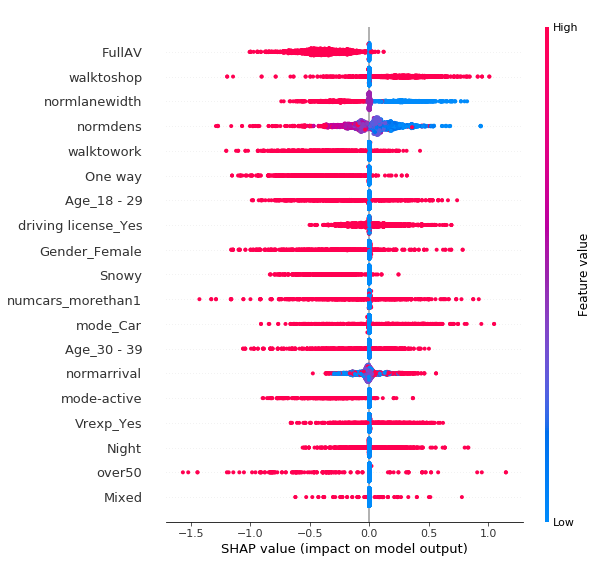

In [294]:
shap.summary_plot(shap_values[0], dfxtrainsub,max_display=20)

In [296]:
def greaterthanmean(col):
    ColMean=col.mean()
    BlueIndex=col[col<=ColMean].index     #indices of feature values less than (or eq to) avg of feature
    return BlueIndex

Blues = {'normarrival': greaterthanmean(dfxtrainsub['normarrival']),
         'normdens': greaterthanmean(dfxtrainsub['normdens']),
        'normlanewidth': greaterthanmean(dfxtrainsub['normlanewidth'])}

In [306]:
shap_df = pd.DataFrame(shap_values[0], copy = True)
shap_df.columns = dfxtrainsub.columns

In [307]:
shap_df['normarrival'][Blues['normarrival']] = shap_df['normarrival'][Blues['normarrival']]*(-1)

In [308]:
shap_df['normdens'][Blues['normdens']] = shap_df['normdens'][Blues['normdens']]*(-1)
shap_df['normlanewidth'][Blues['normlanewidth']] = shap_df['normlanewidth'][Blues['normlanewidth']]*(-1)

In [309]:
mean=shap_df[shap_df!=0].mean()              #mean of shap values for each feature (non-zeros only

nonzeros=shap_df.astype(bool).sum(axis=0)        #count of non-zeros shap values for each feature

std=shap_df[shap_df!=0].std()                #standard deviation of shap values for each feature

featuresshap=pd.DataFrame()

featuresshap['count']=nonzeros
featuresshap['mean']=mean                 #bg0: zeros set as background data

featuresshap['std']=std

featuresshap['absmean']=abs(mean)

In [310]:
featuresshap.sort_values(by=['absmean'])

,count,mean,std,absmean
Mixed,80,-0.012801,0.264169,0.012801
driving license_Yes,1673,0.019957,0.191379,0.019957
Night,616,0.026859,0.220426,0.026859
normarrival,1822,0.029557,0.123448,0.029557
Vrexp_Yes,757,0.058912,0.235346,0.058912
mode_Car,607,0.067900,0.354999,0.067900
numcars_morethan1,759,-0.109959,0.344315,0.109959
Age_30 - 39,671,-0.111336,0.299177,0.111336
normdens,1831,-0.169123,0.184794,0.169123
Age_18 - 29,864,-0.181600,0.312172,0.181600
